# Dynamic and static targets study

In [15]:
PATH_PREFIX = '../../../'
import sys
sys.path.append(PATH_PREFIX)

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
import csv
from utils.plot import *
from utils.fitness_controller import FitnessController
from compress_optim import CompressConfig, load_comp_config, fit_from_vals

In [17]:
NET_TYPE = 'relu'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_locked/'), 'type': 'statický'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'extremní dynamický'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic/'), 'type': 'přednastavený dynamický'}
    ]

FOLDERS = [
    f'lenet_{NET_TYPE}_compress_50_dynamic',
    f'lenet_{NET_TYPE}_compress_50_locked',
    f'lenet_{NET_TYPE}_compress_50_extrem_dynamic',
]

FILE_FILT_SHOW = [
    'GA_save.csv', 
    'PSO_save.csv',
    'BH_save.csv',
]

SAVE_FILES = {
    'RND_save.csv': 'RND',
    'PSO_save.csv': 'PSO',
    'GA_save.csv': 'GA',
    'BH_save.csv': 'BH',
}

ACC_TRESHOLD = 0.01

SAVE_PLOTS = True
SAVE_PLOTS_LOC = os.path.join(PATH_PREFIX, 'results/graphs/lenet/targs')
os.makedirs(SAVE_PLOTS_LOC, exist_ok=True)
SAVE_PLOT_ID = f'{NET_TYPE}_locked'

Compare data

In [18]:
data = {
    'acc': [],
    'run': [],
    'cr': [],
    'opt': [],
    'folder': [],
}

for folder in FOLDERS:
    for run in [f'run{x}' for x in range(1, 12)]:
        for file in os.listdir(os.path.join(PATH_PREFIX, 'results', folder, run)):
            df = pd.read_csv(os.path.join(PATH_PREFIX, 'results', folder, run, file))
            best_row = df[df['accuracy'] == df['accuracy'].max()]
            data['acc'].append(list(best_row['accuracy'])[0])
            data['run'].append(run)
            data['cr'].append(list(best_row['compression'])[0])
            data['opt'].append(SAVE_FILES[file])
            data['folder'].append(folder)


data = pd.DataFrame(data)
data.sort_values('acc', ascending=False)

,acc,run,cr,opt,folder
21,0.9874,run8,6.180161,BH,lenet_relu_compress_50_dynamic
15,0.9872,run6,5.734098,BH,lenet_relu_compress_50_dynamic
100,0.9872,run8,5.525160,PSO,lenet_relu_compress_50_extrem_dynamic
59,0.9872,run7,5.336558,PSO,lenet_relu_compress_50_locked
67,0.9870,run9,5.649527,PSO,lenet_relu_compress_50_locked
...,...,...,...,...,...
88,0.9858,run4,5.942513,PSO,lenet_relu_compress_50_extrem_dynamic
32,0.9856,run11,5.636476,PSO,lenet_relu_compress_50_dynamic
69,0.9856,run10,5.423571,BH,lenet_relu_compress_50_locked
108,0.9856,run11,4.688146,GA,lenet_relu_compress_50_extrem_dynamic


In [19]:
fit_conts:list[FitnessController] = []

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'Typ bodů': [],
    'Typ cíle': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'], CompressConfig.OPTIM_TARGET, CompressConfig.OPTIM_TARGET_LOCK)

    # update corresponding global fitness controller target
    fit_conts.append(FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
        target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK))

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:

            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            fit_conts[-1].fit_from_df(save_df, verbose=True)

    print(fit_conts[-1].targ)

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))

            save_df = save_df[save_df['accuracy_loss'] < ACC_TRESHOLD]

            # dropping fitness column if found
            if 'fitness' in save_df.columns:
                #old_fit[key].append(save_df['fitness'].max())
                save_df = save_df.drop('fitness', axis=1)

            with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
                load_comp_config(yaml.safe_load(config))

            # update corresponding global fitness controller target
            local_fit = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
                target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

            # get correct fitness row by current fitness controller
            local_fit.fit_from_df(save_df, verbose=True)

            # saving best found row
            data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
            
            data_complete['run'].append(dir)
            data_complete['accuracy'].append(data_row['accuracy'])
            data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
            data_complete['compression'].append(data_row['compression'])
            data_complete['fitness'].append(data_row['fitness'])
            data_complete['Typ bodů'].append(SAVE_FILES[file])
            data_complete['Typ cíle'].append(experiment['type'])

data_complete = pd.DataFrame(data_complete)

../../../results/lenet_relu_compress_50_locked/ [0.99, 14.0] True
[ 0.99 14.  ]
../../../results/lenet_relu_compress_50_extrem_dynamic/ [0.01, 1.0] False
Fitness target update to [ 0.9872   12.023792]
Fitness target update to [ 0.9872   13.833873]
Fitness target update to [ 0.9882   13.833873]
Fitness target update to [ 0.9882   14.334991]
[ 0.9882   14.334991]
Fitness target update to [ 0.9872   10.933984]
Fitness target update to [ 0.9872   11.873258]
Fitness target update to [ 0.9876   12.222055]
Fitness target update to [ 0.9878   11.750088]
Fitness target update to [ 0.9876   11.900544]
Fitness target update to [ 0.987    12.225219]
Fitness target update to [0.9872   9.410969]
Fitness target update to [ 0.9874   11.961195]
Fitness target update to [ 0.9868   11.864382]
Fitness target update to [ 0.9872   11.949678]
Fitness target update to [ 0.9872   12.800146]
Fitness target update to [ 0.9878   10.913166]
Fitness target update to [ 0.9872   10.158294]
Fitness target update to [ 

In [20]:
data_complete['accuracy_loss'] = data_complete['accuracy_loss'] * 100
data_complete['accuracy'] = data_complete['accuracy'] * 100


before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss']


pareto_front = pareto_from_df(data_complete)

for i, fit_cont in enumerate(fit_conts):
    data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0] * 100, before_loss - (fit_cont.targ[0] * 100), fit_cont.targ[1], 100, 'Cíl', FOLDERS_EXP[i]['type']]

data_complete

,run,accuracy,accuracy_loss,compression,fitness,Typ bodů,Typ cíle
0,run7,97.62,0.84,11.278108,5.130312,BH,statický
1,run7,97.72,0.74,12.067324,7.212279,GA,statický
2,run7,97.48,0.98,10.211877,3.689826,PSO,statický
3,run3,97.66,0.80,10.130688,3.613883,BH,statický
4,run3,97.48,0.98,11.182282,4.954165,GA,statický
...,...,...,...,...,...,...,...
97,run6,97.88,0.58,12.709639,10.768858,GA,přednastavený dynamický
98,run6,97.60,0.86,12.133573,7.459116,PSO,přednastavený dynamický
99,run0,99.00,-0.54,14.000000,100.000000,Cíl,statický
100,run0,98.82,-0.36,14.334991,100.000000,Cíl,extremní dynamický


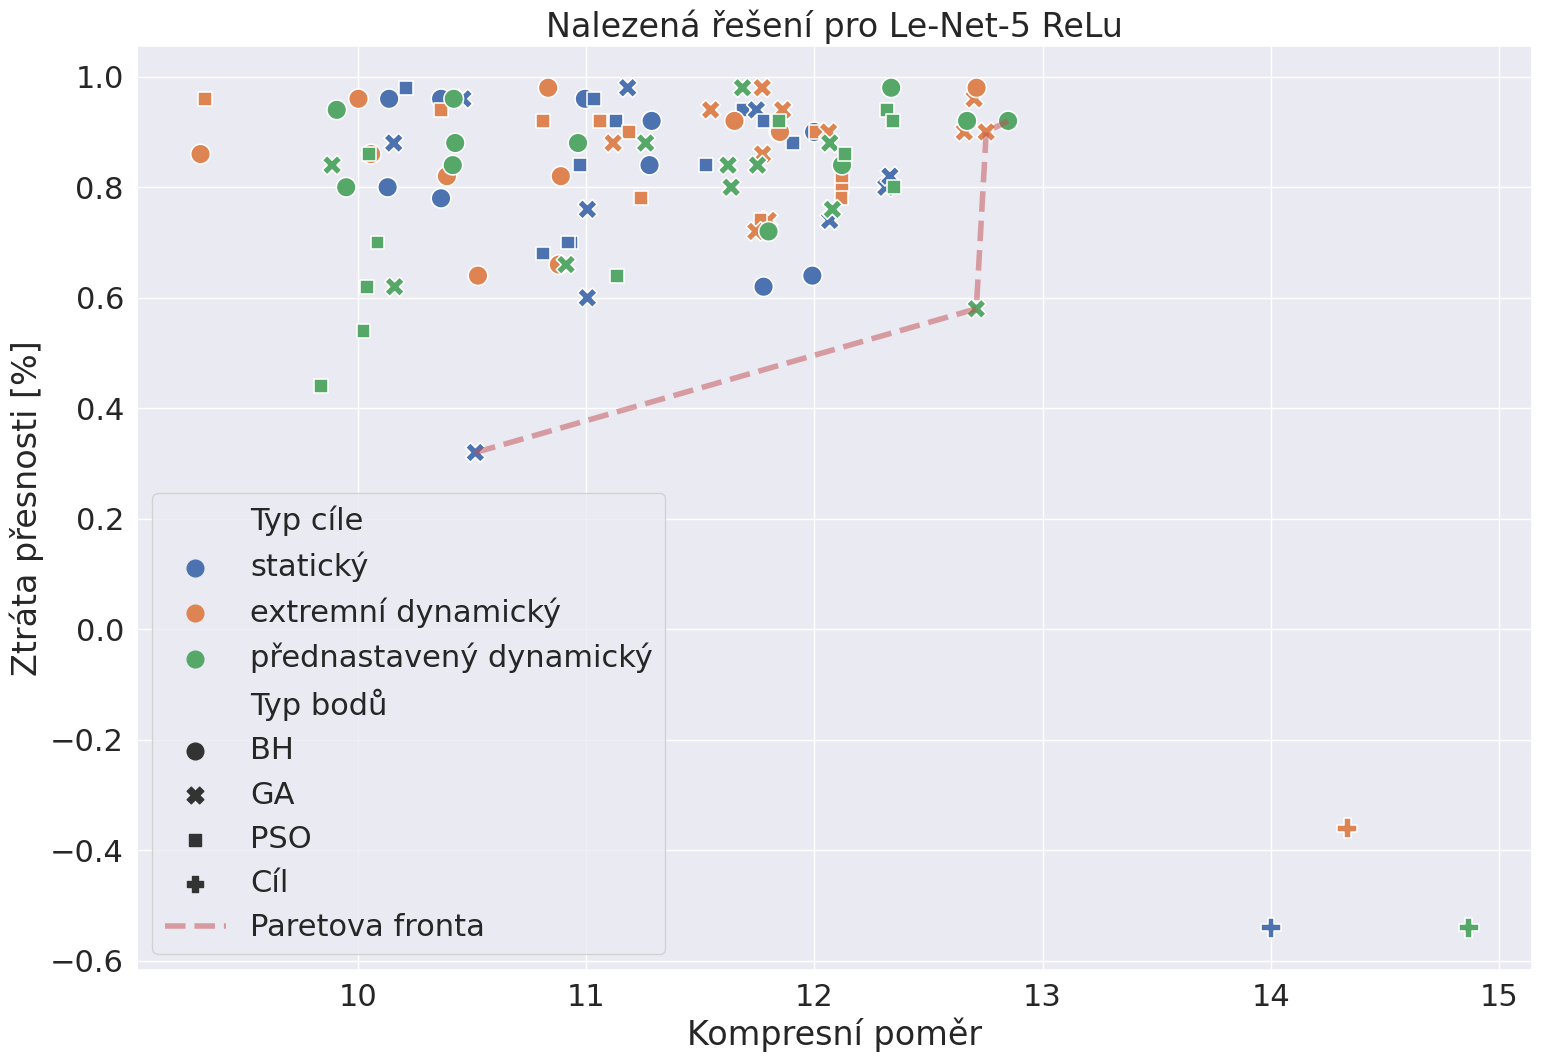

In [21]:
sns.set(rc={'figure.figsize': (18, 12)}, font_scale=2)
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', hue='Typ cíle', s=200, style='Typ bodů')

plt.plot(list(pareto_front['compression']), list(pareto_front['accuracy_loss']) , 'r--', alpha=0.5, label='Paretova fronta', linewidth=4)
plt.legend(markerscale=2)
plt.xlabel('Kompresní poměr')
plt.ylabel('Ztráta přesnosti [%]')
plt.title(f'Nalezená řešení pro Le-Net-5 {"ReLu" if NET_TYPE == "relu" else "Tanh"}')

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'lenet_target_plot_{SAVE_PLOT_ID}.pdf'))